In [699]:
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib.pyplot import * 
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
color = sns.color_palette()
from scipy.stats import skew
%matplotlib inline



train_raw = pd.read_csv("train.csv", parse_dates=['timestamp']).drop(['id'],axis=1)
test_raw= pd.read_csv("test.csv", parse_dates=['timestamp']).drop(['id'],axis=1)
macro= pd.read_csv("macro.csv", parse_dates=['timestamp'])
#Getting those macro columns with less than 10% of missing values
macro_col_null = macro.isnull().mean(axis=0) < 0.10
macro_useful = macro_col_null[macro_col_null.values==True].index
macro_imp = macro[macro_useful]


In [700]:
# Get rid of observations with high freq observations
#observing the useful macro dataset to eliminate features that have very few unique values
for column in macro_imp.columns :
    if macro_imp[column].nunique() < 100 :
        print column, np.array(sorted(macro_imp[column].unique()))
    else :
        print column, macro_imp[column].nunique()

# prints number of unique observations if available, else prints only 100 values

timestamp 2484
oil_urals [  29.1125   30.5943   36.6171   36.7805   39.9762   42.3962   43.6614
   43.8159   44.3677   45.0185   45.5825   46.3414   46.6518   47.0118
   47.3436   54.6423   55.8961   57.863    59.1295   61.2833   61.4105
   63.3737   72.97     73.05     73.62     74.05     75.4      76.1      77.03
   77.6      78.9665   81.49     82.87     84.9      86.6257   89.56
   93.74     93.82     95.6732  100.96    101.4165  101.99    102.62
  102.78    103.34    105.6383  106.8776  107.076   107.1991  107.4
  107.843   107.9     107.9176  107.988   108.1613  108.24    108.6
  108.6204  108.65    109.2     109.31    109.6476  109.91    110.23
  110.43    110.622   111.14    111.27    111.29    111.3933  111.54
  111.73    111.8138  111.92    113.09    114.51    115.74    117.87
  119.03    119.33    122.52  ]
gdp_quart [     nan   9995.8  10977.   12086.5  12844.3  13249.3  14313.7  14925.
  15663.6  15891.7  16149.   16876.6  17015.1  17138.9  17442.1  18209.7
  18410.7  1854

In [716]:
# number of unique values 
for column in macro_imp.columns :
    print column, macro_imp[column].nunique()

timestamp 2484
oil_urals 81
gdp_quart 26
gdp_quart_growth 23
cpi 78
ppi 81
balance_trade 80
balance_trade_growth 26
usdrub 1754
eurrub 1760
brent 1474
gdp_annual 7
gdp_annual_growth 7
average_provision_of_build_contract 25
rts 1680
micex 1656
micex_rgbi_tr 1063
micex_cbi_tr 1511
deposits_value 74
deposits_growth 73
mortgage_value 81
mortgage_rate 66
fixed_basket 81


In [717]:
# number of unique values 
for column in train_raw.columns :
    print column, train_raw[column].nunique()

timestamp 1161
full_sq 211
life_sq 175
floor 41
max_floor 49
material 6
build_year 119
num_room 13
kitch_sq 74
state 5
product_type 2
sub_area 146
area_m 146
raion_popul 146
green_zone_part 146
indust_part 132
children_preschool 146
preschool_quota 121
preschool_education_centers_raion 13
children_school 146
school_quota 125
school_education_centers_raion 14
school_education_centers_top_20_raion 3
hospital_beds_raion 79
healthcare_centers_raion 7
university_top_20_raion 4
sport_objects_raion 24
additional_education_raion 12
culture_objects_top_25 2
culture_objects_top_25_raion 6
shopping_centers_raion 16
office_raion 30
thermal_power_plant_raion 2
incineration_raion 2
oil_chemistry_raion 2
radiation_raion 2
railroad_terminal_raion 2
big_market_raion 2
nuclear_reactor_raion 2
detention_facility_raion 2
full_all 146
male_f 146
female_f 146
young_all 146
young_male 145
young_female 145
work_all 145
work_male 145
work_female 146
ekder_all 146
ekder_male 146
ekder_female 146
0_6_all 146
0_6

In [702]:
# Based on the above output, taking a subset of features to join with training
macro_feat = ['timestamp', 'oil_urals', 'cpi', 'usdrub', 'rts', 'mortgage_rate', 'balance_trade', 'brent', 'micex', 'micex_cbi_tr', 'micex_rgbi_tr', 'fixed_basket']
macro_usefeat = macro[macro_imp2]

In [703]:
#concatenating train and test by leaving out price, then merging important features in macro 

join_df = pd.concat((train_raw.loc[:,:'market_count_5000'],
                      test_raw.loc[:,:'market_count_5000']))


df = pd.merge(join_df, macro_usefeat, on = 'timestamp', how='left')

In [704]:
#log transform skewed data for normality assumption

train_raw["price_doc"] = np.log1p(train_raw["price_doc"])

#log transform skewed numeric features
#get skewed columns
get_col = df.dtypes[(df.dtypes == "int64") | (df.dtypes == "float64")].index

get_skews = df[get_col].apply(lambda x: skew(x.dropna()))
get_skews = get_skews[get_skews>0.75]
get_skews = get_skews.index

df = pd.get_dummies(df)
#fill na with mean
df = df.fillna(df.mean())


In [705]:
#apply normality to columns in both train and test data
df[get_skews] = np.log1p(df[get_skews])

In [706]:

train_time = df[:train_raw.shape[0]]
test = df[train_raw.shape[0]:]
#train_price = train_raw.price_doc

train = train_time.drop(['timestamp'], axis=1)

train_price = train_raw.price_doc

In [707]:
def rmsle_cv(model):
    rmsle= np.sqrt(-cross_val_score(model, train, train_price, scoring="neg_mean_squared_error", cv = 5))
    return(rmsle)

In [708]:
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 0.5, 1, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

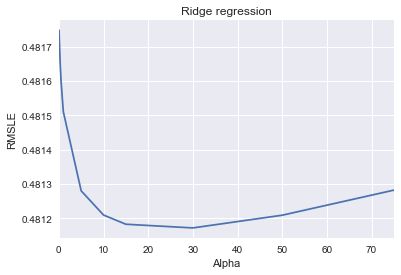

In [709]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge regression")
plt.xlabel("Alpha")
plt.ylabel("RMSLE")

In [710]:
cv_ridge.min() #error in Ridge regression

0.48117238078123548

In [711]:
model_lasso = LassoCV(alphas = [0.1,0.3, 0.5,1,2,3,4,5]).fit(train, train_price)

In [712]:
rmsle_cv(model_lasso).min() #error in Lasso regression

0.52902010519453213

In [713]:
feat = pd.Series(model_lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(feat != 0)) + " features")
print (str(sum(feat == 0)) + " features were removed")

Lasso picked 19 features
435 features were removed


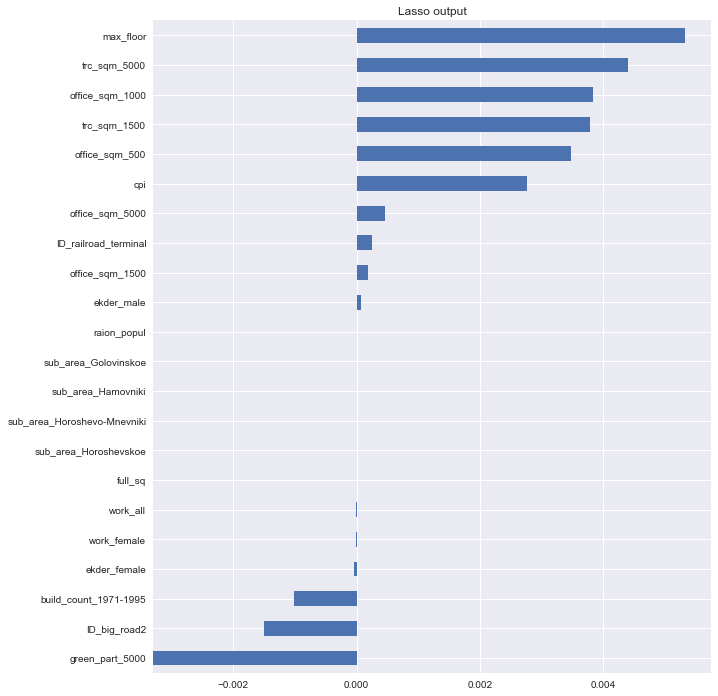

In [714]:
features = pd.concat([feat.sort_values().head(11), feat.sort_values().tail(11)])
matplotlib.rcParams['figure.figsize'] = (10, 12)
features.plot(kind = "barh")
plt.title("Lasso output")

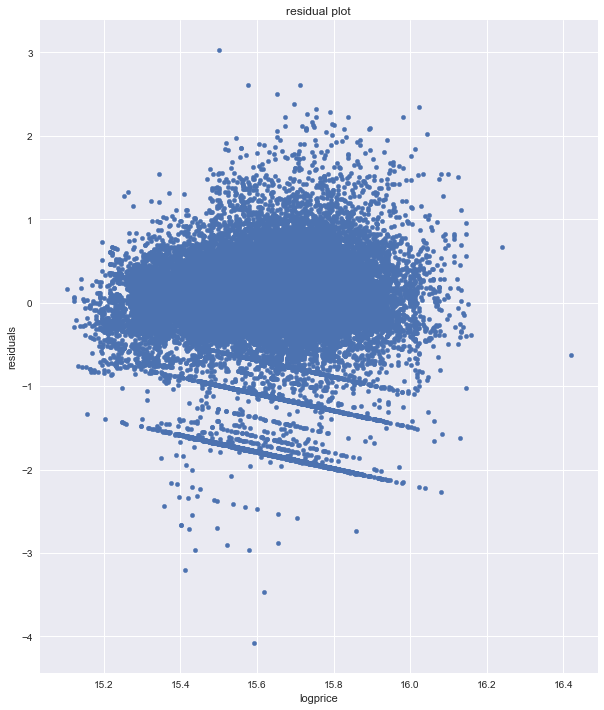

In [718]:
logprice = pd.DataFrame({"logprice":model_lasso.predict(train), "true":train_price})
logprice["residuals"] = logprice["true"] - logprice["logprice"]
logprice.plot(x = "logprice", y = "residuals",kind = "scatter")
plt.title("residual plot")